In [1]:
import setuptools; import numpy as np; from copy import copy; import matplotlib; import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

#Cython: Blend the best of python and C++

Cython is a superset of python language that can generate C code that compiles with all major C/C++ compilers.

Cython allows you to:

+ Easily tune readable Python code into plain C adding static type declarations.
+ Wrapp external C libraries


<img src="cython-wf.png" height="300" >



Let's start with a simple python function:

In [1]:
def fibonatti(n):
    if n < 2:
        return n
    fibPrev = 1
    fib = 1
    for num in xrange(2, n):
        fibPrev, fib = fib, fib + fibPrev
    return fib

In [2]:
for i in xrange(1,10):
    print fibonatti(i),

1 1 2 3 5 8 13 21 34


And boost its performance by cythonizing the piece of code:

####"cython_examples.pyx"

``` cython
cpdef int fibonatti(int n):
    cdef int fib, fibPrev, num
    if n < 2:
        return n
    fibPrev = 1
    fib = 1
    for num in xrange(2, n):
        fibPrev, fib = fib, fib + fibPrev
    return fib
```

In [5]:
from cython_examples import fibonatti as cfibonatti

In [6]:
for i in xrange(1,10):
    print cfibonatti(i),

1 1 2 3 5 8 13 21 34


In [21]:
%timeit fibonatti(1000000)

1 loops, best of 3: 11.1 s per loop


In [7]:
%timeit cfibonatti(1000000)

1000 loops, best of 3: 652 µs per loop


##Compiling a cython module

Cython is Python with C data types. As Cython can accept almost any valid python source file, one of the hardest things in getting started is just figuring out how to compile your extension. Python code are stored in .pyx files.

There are three basic ways to compile and load cython modules into your python code:

###1. Creating a setup.py script

####setup.py
```python
from setuptools import setup
from Cython.Build import cythonize

setup(
  name = 'Cython examples',
  ext_modules = cythonize("cython_examples.pyx"),
)
```

From command line:
```shell
python setup.py build_ext --inplace
```

###2. Using pyximport
If the module doesn’t require any extra C libraries pxyimport can be used to directly compile and load the module from a .pyx file


In [7]:
import pyximport
pyximport.install()
import cython_examples_with_pyximport

for i in xrange(1,10):
    print cython_examples_with_pyximport.fibonatti(i),

1 1 2 3 5 8 13 21 34


###3. In Ipython Notebooks:

In [8]:
 %load_ext Cython

In [12]:
%%cython
cpdef int ipython_fibonatti(int n):
    cdef int fib, fibPrev, num
    if n < 2:
        return n
    fibPrev = 1
    fib = 1
    for num in xrange(2, n):
        fibPrev, fib = fib, fib + fibPrev
    return fib

In [10]:
for i in xrange(1,10):
    print ipython_fibonatti(i),

1 1 2 3 5 8 13 21 34


#Cython syntax
+ Implementation files carry a **.pyx** suffix
+ **.pxd** files can hold definitios of functions, classes so they can be used by other cython modules. These files can also contain wrappers fro c functions as cython distribution have **numpy.pxd** for example (we will get back to these)

##Defining c types
The **cdef** statement is used to **declare C variables**, either local or module-level:

In [10]:
%%cython
cdef int i, j, k
cdef float f
cdef double g[42]
cdef char *h

In [13]:
%%cython 
cdef struct TadeuDesk:
    int mug_counter
    char* next_proposal_name
    
cdef enum CheeseType:
    cheddar, edam,
    camembert

cdef enum CheeseState:
    hard = 1
    soft = 2
    runny = 3
    
cdef TadeuDesk desk
desk.mug_counter = 3
    
my_cheesetype = cheddar
if my_cheesetype != camembert:
    print "not my kind of cheese"

Also, classes (another topic we will et back in detail soon)

In [13]:
%%cython
cdef class Guga(object):
    cpdef greeting(self):
        cdef int i        
        for i in range(3):
            print "I love linux!"

In [14]:
guga = Guga()
guga.greeting()

I love linux!
I love linux!
I love linux!


There is also a **ctypedef** statement for giving names to types, e.g.:

In [15]:
%%cython
ctypedef unsigned long u_long

Use the **cimport** statement, as you would Python’s import statement, to access these files from other definition or implementation files.

In [ ]:
%%cython
from libc.math cimport sqrt

print sqrt(2.0)

##Grouping declarations

In [15]:
%%cython
cdef:
    int a
    int b
    struct BookMeeting:
        int participants

##Functions and methods declarations

There are **three** types of function declarations in Cython

Only “Python” functions can be called outside a Cython module from Python interpreted code.

###Callable from Python

- Are declared with the **def** statement
- Are called with Python objects
- Return Python objects
- See Parameters for special consideration

###Callable from C

- Are declared with the **cdef** statement.
- Are called with either Python objects or C values.
- Can return either Python objects or C values.

###Callable from both Python and C
- Are declared with the **cpdef** statement.
- Can be called from anywhere, because it uses a little Cython magic.
- Uses the faster C calling conventions when being called from other Cython code.
Overriding

The directive cpdef makes two versions of the method available; one fast for use from Cython and one slower for use from Python. Then:

In [40]:
%%cython

def lala(a):
    return a

cdef int lalala(int a):
    return a

cpdef int lalalala(int a):
    return a

def lele(p):    
    return lalala(p)
    
cdef lili():
    return lala(2)
    
print lili()
print lele(2)
print lele(2.5)

2
2
2


In [41]:
print lala(1)

try:
    print lalala(2)
except:
    print "Hello my friends, I told you so"
    
print lalalala(3)

1
Hello my friends, I told you so
3


##Parameters

Both **C** and **Python** function types can be declared to have parameters C data types.

Use normal C declaration syntax:

In [52]:
%%cython
cpdef sum(int a, int b):
    return a + b

In [53]:
type(sum(1,2))

int

If no type is specified for a parameter or a return value, **it is assumed to be a Python object**
The following takes two Python objects as parameters and returns a Python object:


In [48]:
%%cython
cdef sum(a,b):
    return a + b

print sum(1,2)

3


**Optional arguments** can be used:

In [59]:
%%cython
def sum(int a, int b=2):
    return a + b

In [58]:
sum(1)

3

#Let's try it out!

In [112]:
from math import sin

def f(x):
    return sin(x**2)

def integrate_f(a, b, N):
    dx = (b-a)/N
    s = 0
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

In [113]:
%timeit integrate_f(0.0, 1.0, 1000000)

1 loops, best of 3: 465 ms per loop


## Declaring c types and function parameters

In [118]:
%%cython
from math import sin

def f(double x):
    return sin(x**2)

def cintegrate_f(double a, double b, int N):
    cdef double dx, s
    cdef int i
    
    dx = (b-a)/N
    s = 0
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

In [ ]:
%timeit cintegrate_f(0.0, 1.0, 1000000)

## Declaring cython functions

In [77]:
%%cython
from math import sin

cdef double f(double x):
    return sin(x**2)

def cintegrate_f(double a, double b, int N):
    cdef double dx, s
    cdef int i
    
    dx = (b-a)/N
    s = 0
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

In [ ]:
%timeit cintegrate_f(0.0, 1.0, 1000000)

##Calling external C/C++ functions

In [109]:
%%cython
from libc.math cimport sin

cpdef double f(double x):
    return x

cpdef double cintegrate_f(double a, double b, int N, rn):
    cdef double dx, s
    cdef int i
    
    dx = (b-a)/N
    s = 0
    for i in rn:
        s += f(a+i*dx)
#    i = 0
#    while i < N:
#        s += f(a+i*dx)
        i += 1
    return s * dx

In [111]:
%timeit cintegrate_f(0.0, 1.0, 1000000, range(1000000))

10 loops, best of 3: 20.1 ms per loop


In [31]:
%%cython
cdef extern from "math.h":
    double sin(double)
    
cpdef double f(double x):
    return sin(x**2)

cpdef double cintegrate_f(double a, double b, int N):
    cdef double dx, s
    cdef int i
    
    dx = (b-a)/N
    s = 0
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

In [32]:
%timeit cintegrate_f(0, 1, 1000000)

10 loops, best of 3: 76.3 ms per loop


#Python syntax
The advantage is to use **plain python code** (no need to change original code). The drawback is that it **doesn't allow access to C functions** (cannot override from math import sin)

In [33]:
import cython
from math import sin

@cython.locals(x=cython.double)
def f(x):
    return sin(x**2)

@cython.locals(a=cython.double, b=cython.double,
               N=cython.int, dx=cython.double,
               s=cython.double, i=cython.int)
def integrate_f(a, b, N):
    dx = (b-a)/N
    s = 0
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

In [34]:
%timeit cintegrate_f(0, 1, 1000000)

10 loops, best of 3: 76.4 ms per loop


#Declaring python types is valuable:

Access to Python's builtins is heavily optimised
- loops: (for ... in range()/list/tuple/dict)
- list.append(), list.reverse()
- set([...]), tuple([...])

In [35]:
import string
d = { s:s for s in string.ascii_letters }
print d

{'A': 'A', 'C': 'C', 'B': 'B', 'E': 'E', 'D': 'D', 'G': 'G', 'F': 'F', 'I': 'I', 'H': 'H', 'K': 'K', 'J': 'J', 'M': 'M', 'L': 'L', 'O': 'O', 'N': 'N', 'Q': 'Q', 'P': 'P', 'S': 'S', 'R': 'R', 'U': 'U', 'T': 'T', 'W': 'W', 'V': 'V', 'Y': 'Y', 'X': 'X', 'Z': 'Z', 'a': 'a', 'c': 'c', 'b': 'b', 'e': 'e', 'd': 'd', 'g': 'g', 'f': 'f', 'i': 'i', 'h': 'h', 'k': 'k', 'j': 'j', 'm': 'm', 'l': 'l', 'o': 'o', 'n': 'n', 'q': 'q', 'p': 'p', 's': 's', 'r': 'r', 'u': 'u', 't': 't', 'w': 'w', 'v': 'v', 'y': 'y', 'x': 'x', 'z': 'z'}


In [36]:
def filter(d):
    return { key : value
             for key, value in d.iteritems()
             if 'a' not in value }

In [37]:
%timeit filter(d)

100000 loops, best of 3: 5.39 µs per loop


In [38]:
%%cython
def filter(dict d):
    return { key : value
             for key, value in d.iteritems()
             if 'a' not in value }

In [39]:
%timeit filter(d)

100000 loops, best of 3: 2.61 µs per loop


#Classes (working with extension types)

In [40]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt

cdef class DiscreteSPhere(object):    
    
    cdef np.ndarray m_center
    cdef public int squared_radius # Available in Python-space:
    
    property center:
        def __get__(self):
            return self.m_center
        def __set__(self, value):
            self.m_center = value
    
    def __init__(self, center, squared_radius):
        self.m_center = center
        self.squared_radius = squared_radius
    
    
    cpdef double radius(self):
        return sqrt(self.squared_radius)

In [41]:
s1 = DiscreteSPhere(np.array([1,1,1]), 2)
print s1.center
print s1.radius()

[1 1 1]
1.41421356237


#Let's tune our previous example

In [42]:
%%cython
from libc.math cimport sin

cdef class Function:
    cpdef double evaluate(self, double x) except *:
        return 0   

cdef class SinOfSquareFunction(Function):
    cpdef double evaluate(self, double x) except *:
        return sin(x**2) 

cpdef double integrate(Function f, double a, double b, int N):
    cdef int i
    cdef double s, dx    
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f.evaluate(a+i*dx)
    return s * dx

In [43]:
my_func = SinOfSquareFunction()

In [44]:
%timeit integrate(my_func, 0.0, 1.0, 1000000)

10 loops, best of 3: 80.9 ms per loop


#Using .pxd files
From **sci20** code documentation standards:
```C++
//TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO 
```

#Working with Numpy

In [67]:
%%cython
import numpy as np
cimport numpy as np

cdef np.ndarray my_array = np.zeros(3,dtype=np.int)

cpdef np.ndarray sum_1_for_each_element(np.ndarray[np.float64_t, ndim=1] vec):
    return vec + np.ones(1, dtype=np.float64)

In [68]:
print sum_1_for_each_element(np.array([1.0,2.0,3.0,4.0]))

[ 2.  3.  4.  5.]


#2D Heat diffusion with finite volume and explicit formulation

Solve:

$$\frac{\partial \left(\rho cp T\right)}{\partial t} = \frac{\partial }{\partial x}\left(k \frac{\partial T}{\partial x}\right) + \frac{\partial }{\partial y}\left(k \frac{\partial T}{\partial y}\right)$$

For a wall domain initially at 0°C, with the following geometry and boundary conditions

<img src="wall.png" height="260" >

In [55]:
L = 0.5; M = 50; dt = 0.25

In [62]:
def run_simulation(L, M, dt, total_time=1.0):
    
    # Physical properties --------------------------------------------------------------------------------
    k = 100.0; rho = 1000.0; cp = 4200.0;
    # Geometrical properties -----------------------------------------------------------------------------
    l = L/M; A = l**2; V = l**3.0;    
    assert dt <= (0.9 * rho * cp * (l ** 2) / (4.0 * k))
    # Boundary conditions --------------------------------------------------------------------------------
    u = np.zeros((M,M),dtype=np.float64) # Initial temperature
    u[M-1,:] = 25 # Temperature at top wall
    # ----------------------------------------------------------------------------------------------------

    f = k * A / l # Diffusion term
    B = rho * cp * V / dt # Transient term
    num_timesteps = int(total_time/dt)
    for t in xrange(num_timesteps):                   
        u0 = np.copy(u)                
        for i in xrange(1,M-1):
            for j in xrange(1,M-1):
                u[i,j] = (f*u0[i,j+1] + f*u0[i,j-1] + f*u0[i+1,j] + f*u0[i-1,j] + B*u0[i,j]) / (B + 4*f)
    return u

In [63]:
T = run_simulation(L, M, dt, 1000)

In [55]:
%%timeit
T = run_simulation(L, M, dt, 1000)

1 loops, best of 3: 17.7 s per loop


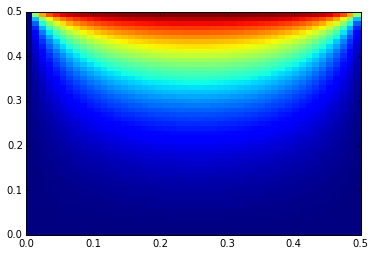

In [64]:
plt.pcolormesh(np.linspace(0, L, M) , np.linspace(0, L, M) , T) 

In [75]:
%%cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float64_t, ndim=2] crun_simulation(double L, int M, double dt, double total_time=1.0):    
    cdef:
        double k, rho, cp, l, A, V, f, B
        int t, i, j, num_timesteps
        np.ndarray[np.float64_t, ndim=2] u, u0
    
    # Physical properties --------------------------------------------------------------------------------
    k = 100.0; rho = 1000.0; cp = 4200.0;
    # Geometrical properties -----------------------------------------------------------------------------
    l = L/M; A = l**2; V = l**3.0;    
    assert dt <= (0.9 * rho * cp * (l ** 2) / (4.0 * k)), 'necessary dt: %f'%((0.9 * rho * cp * (l ** 2) / (4.0 * k)))
    # Boundary conditions --------------------------------------------------------------------------------
    u = np.zeros((M,M),dtype=np.float64) # Initial temperature
    u[M-1,:] = 25 # Temperature at top wall
    # ----------------------------------------------------------------------------------------------------

    f = k * A / l # Diffusion term
    B = rho * cp * V / dt # Transient term

    num_timesteps = int(total_time/dt)
    for t in xrange(num_timesteps):           
        u0 = np.copy(u)        
        for i in xrange(1,M-1):
            for j in xrange(1,M-1):
                u[i,j] = (f*u0[i,j+1] + f*u0[i,j-1] + f*u0[i+1,j] + f*u0[i-1,j] + B*u0[i,j]) / (B + 4*f)
    return u 

In [73]:
T = crun_simulation(L, M, dt, 1000)

In [74]:
%%timeit
T = crun_simulation(L, M, dt, 1000)

1 loops, best of 3: 12.8 s per loop


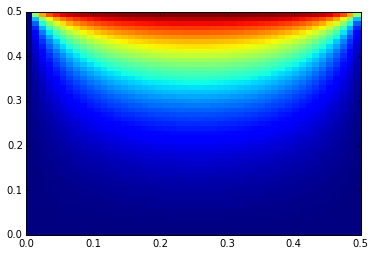

In [71]:
plt.pcolormesh(np.linspace(0, L, M) , np.linspace(0, L, M) , T) 